## Reionization History

#### I plan to show how to calculate the reionization history (neutral fraction as a function of redshift ) in this notebook.  
#### The main idea is to solve the following equation: 

### $ \frac{d Q_{HII}}{dt}  = \frac{\dot{N}_{ion} }{n_H}  - \frac{Q_{HII}}{t_{rec}}$ 

#### where $Q_{HII}$ is the ionized hydrogen density, $\dot{N}_{ion}$ is the ionizing photon production rate, $n_H$ is the (total) gas density, and $t_{rec}$ is the recombination (of ionized H and election) time scale. 

#### We will get the boundary condition (or inital condition) of $Q_{HII}$ and $n_H$ from the cosmolgy package.  They we can iterate the equation above from the inital condition and solve it numerically.  During this process, we need to calculate the $\dot{N}_{ion}$ with our choice of models. 

#### Often the $\dot{N}_{ion}$ can be break down into: 
### $ \dot{N}_{ion} =   f_{esc} \cdot \xi_{ion} \cdot \rho_{UV} $
#### where $f_{esc}$ is the ionizing escape fraction ($f^{LyC}_{esc}$), $\xi_{ion}$ is the ionizing photon production efficiency, and $\rho_{UV}$ is the UV luminosity function. Let's check the dimension:   
### $\dot{N}_{ion} [s^{-1} /Mpc^{3}]~~~$;   $~~~f_{esc} []~~~$  $\xi_{ion} [s^{-1} / (erg~ s^{-1} Hz^{-1})]~~~$  $\rho_{UV} [erg~ s^{-1} Hz^{-1}/Mpc^{3}]$ 

#### For simplicity,  I will assume a constant  $f_{esc}$ and $\xi_{ion}$ to get to the result.  You can adjust the code to generalize these parameters to your need. 


#### Notation:  opz = 1 + z ,  where z = redshift.   R_ion = $\dot{N}_{ion}$, ionizing photon production "Rate".  

In [1]:
import numpy as np 
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u
from scipy.interpolate import interp1d
from scipy import integrate
import matplotlib.pyplot as plt

####### Constants 
Mpc_per_cm  = 3.086e+24 # Mpc to cm
proton_mass = 1.6726219e-24 # gram
fH = 0.76 # hydrogen mass fraction, 0.24 is helium.
Gyr_per_sec = 3.15e16 # Gyr to sec
alpha = 4.2e-13 # cm^3 s^-1 



#######  Handy function 
def d_pc(opz):
    d_pc=Planck18.luminosity_distance(z=(opz-1)).value*1e6 
    return d_pc

def d_cm(opz):
    d_cm=Planck18.luminosity_distance(z=(opz-1)).value*1e6*3.086e18 
    return d_cm


def ABMag(mag, opz): 
    return mag-5*np.log10(d_pc(opz)*1e-6)-25+2.5*np.log10(opz)

def ABMag_to_mag(ABMag, opz): 
    return ABMag +5*np.log10(d_pc(opz)*1e-6) + 25 -2.5*np.log10(opz)

def mag_to_flux(mag): 
    return np.power(10, -(mag+48.60)/2.5)


#### We define the Luminosity function (LF) here, which is a Schechter function in magnitude form.  
#### There are more faint objects, and less bright objects. 
#### $\rho_{UV}$ will be integrating the luminosity function from the bright end to the faint end. 

In [15]:
def LF(M, opz):  # https://ui.adsabs.harvard.edu/abs/2015ApJ...803...34B/abstract
    psi = 0.44*10**(-0.28*(opz-7))*1e-3
    alpha = -1.87 + (-0.1)*(opz - 7)
    M0 = -20.97
    nM = 0.4*np.log(10)*psi*np.power( 10**( 0.4*(M0-M) ), alpha+1 ) * np.exp(-10 ** ( 0.4*(M0-M)) )
    return nM 

def LF(M, opz):  # https://iopscience.iop.org/article/10.3847/1538-3881/abf83e/meta
    psi = 0.40*1e-3*10**(-0.33*(opz-7)+(-0.024*(opz - 7)**2))
    alpha = -1.94 + (-0.11)*(opz - 7)
    M0 = -20.97
    opzt = 2.46 + 1
    if opz > opzt: 
        M0 = -21.03 + (-0.04)*(opz - 7)
    
    nM = 0.4*np.log(10)*psi* np.power( 10**( 0.4*(M0-M) ), alpha+1 ) * np.exp(-10 ** ( 0.4*(M0-M)) )
    return nM 


def Mag_to_L(M, opz): 
    flux = mag_to_flux(M)
    L  = flux  * 4*np.pi*(10*3.086e+18)**2 
    return L


def Rion(fesc, xi_ion, rho_UV ): 
    Ndot = fesc * 10**xi_ion * rho_UV 
    return Ndot

#### Let's plot the luminosity function, integrating from -23 (birghtest) to -16 (faintest). 
#### There are very few objects brighter than UV Mag = -23.  Objects fianter than UV Mag = -16 is too faint to contribute significant amount of photons.  
#### ( You can vary the mag_range and integrate $R_{ion}$ to see if it's truth. ) 

ionizing photon rate= 1.5056E+50


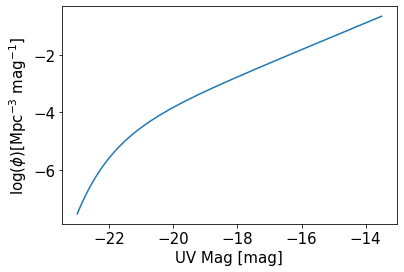

In [16]:
## At redshift of 8: 
opz = 1+8
mag_range = np.arange(-13.5, -23, -0.001 )
L_range = Mag_to_L(mag_range, opz )

# integral over UV:  integral = simps(y, x) 
tot_UV = integrate.simps(LF(mag_range, 9), L_range) 
Rion_range = Rion(fesc = 0.1, xi_ion = 25.2, rho_UV = tot_UV)
print('ionizing photon rate=',"{:.4E}".format( Rion_range) )


fig, ax = plt.subplots(1,figsize=(6,4))
x = mag_range
y = np.log10(LF(mag_range, opz) ) 

ax.plot(x ,y )
ax.set_xlabel('UV Mag [mag]', fontsize=15)
ax.set_ylabel(r'log($\phi$)[Mpc$^{-3}$ mag$^{-1}$]', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)





#### Now we will go and solve the diferential equation.  

#### The input of the function is $f_{esc}$, $\xi_{ion}$, and an array of redshifts. 

#### I start from redshift z0 = 15, where the ionized fraction x0 = 0 
#### In each period of time dt (between redshifts), we will calculate how many ionizing photon we have,  and how many gas we can ionize with the photon, and how many ionized gas gets recommined.  
#### After this we update our ionized fraction, and repeat the calculation. 

In [17]:
Clumping = 3. #(9.25 - 7.21)*np.log10(1.0+z)
def get_xi_with_Rec(fesc, xi_ion,redshift):
    x0 = 0
    z0 = 20
    neutral = []
    for i,z in enumerate(redshift):
        
        mag_range = np.arange(-13.5, -23, -0.1 )
        L_range = Mag_to_L(mag_range, 1+z)
        tot_UV = integrate.simps(LF(mag_range, 1+z), L_range) #np.trapz(LF(mag_range, 1+z), L_range )
        integral = Rion(fesc, xi_ion , rho_UV =tot_UV)
        

        nH   = (Planck18.Ob0*Planck18.critical_density0/ (proton_mass*u.g)*fH).value  # hydrogen density at z
        dt   = (Planck18.lookback_time(z0).value -Planck18.lookback_time(z).value )*Gyr_per_sec # dt
        Rrec = Clumping* (1+fH/ (4*(1-fH))) * alpha * nH *  (1+z)**3.  
        x1   = integral / (nH*Mpc_per_cm**3.0)  * dt  - x0 * Rrec * dt + x0 # integral
        if x1 > 1.0: x1 = 1
        if x1 < 0.0: x1 = 0
        neutral.append(1.-x1)
        x0  = x1
        z0  = z 
    return neutral

#### Say we assume $f_{esc} = 0.1$, $\xi_{ion}$ = 25.2 for all redshift.  
#### The above code will calculate from z=15, how many UV photons we have at a that redshift using Luminosity function, 
#### and how many ionizing photon we have per UV photon density (that's $\xi_{ion}$),
#### and how is that compare with density nH and recombination  Rrec. 

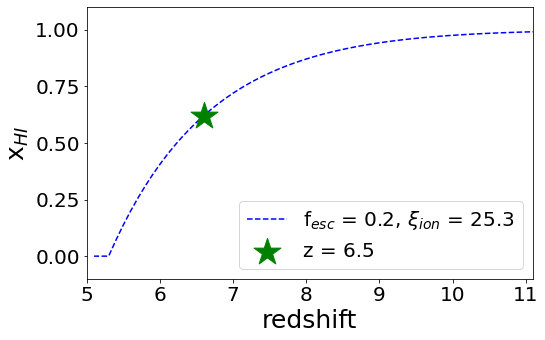

In [20]:
fig, ax = plt.subplots(1,figsize=(8,5))


redshift = np.arange(15, 5, -0.1)
x = redshift
y2 = get_xi_with_Rec(fesc=0.2 , xi_ion = 25.3, redshift = redshift )
ax.plot(x , y2,  'b', ls='--', label=r'f$_{esc}$ = 0.2, $\xi_{ion}$ = 25.3')


redshift = np.arange(15, 6.5, -0.1)
x = redshift
y2 = get_xi_with_Rec(fesc=0.2 , xi_ion = 25.3, redshift = redshift )
ax.scatter(x[-1] , y2[-1],  color='g', marker = '*', s=800, label=r'z = 6.5', zorder=1e10)



ax.set_xlim(5., 11.1)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('redshift', fontsize=25)
ax.set_ylabel(r'x$_{HI}$', fontsize=25)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.legend(loc='lower right', fontsize = 20)

#plt.legend(loc='center left', fontsize = 20, bbox_to_anchor=(0.6, 0.32),framealpha=1)

plt.show()




#### Now you have the reionization history.   

#### In this code,  we solve the neutral fraction evolving from the initial condition (z = 15).  If you'd like to know what is the neutral fraction at given redshift z < 15,  you'll still have to solve the differential equation from the initial condition. 

### Exercise: 

### Q1: 

#### $\xi_{ion}$ is calculated as the following:  
(https://ui.adsabs.harvard.edu/abs/1995ApJS...96....9L/abstract)


### $\xi_{ion} = \frac{L(H\beta)}{4.76\times 10^{-13}} \frac{(1-fesc)^{-1} }{L_{1500}} $

#### $L_{1500}$ is the luminosity of the UV continuum,  which is equivalent to UV Magnitude.  
#### At the first order,  we know that $\xi_{ion}$ is not constant through out all UV magnitudes.  
#### So we have to modified $\xi_{ion}$ as a function of UV Mag into our differential equaiton! 

### Q2: 

#### How to decide the escape fraction $f^{LyC}_{esc}$, if the ionizing photon that escapes the galaxies will still get absorbed by the IGM? 
